# Model Performance

In [22]:
# load libraries
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import yfinance as yf
from numerapi import NumerAPI
from utils.api_keys import PUBLIC_ID, SECRET_KEY

In [23]:
# instantiate
TODAY = dt.datetime.now()
AFTER_DATE = "2022-04-01"
AFTER_ERA = 310

nmr = yf.download('NMR-USD', start=AFTER_DATE, end=TODAY, progress=False)
napi = NumerAPI(public_id=PUBLIC_ID, secret_key=SECRET_KEY)

In [24]:
# get model ranking
def get_model_rankings(model_list):
    df_list = []
    for m in model_list:
        df = pd.DataFrame.from_dict(napi.daily_model_performances(m))
        df['modelName'] = m
        df_list.append( df)
    df_all = pd.concat(df_list)
    return df_all

# get model round performance
def get_model_performance(model_list):
    df_list = []
    for m in model_list:
        df = pd.DataFrame.from_dict(napi.daily_submissions_performances(m))
        df['modelName'] = m
        df_list.append( df)
    df_all = pd.concat(df_list)
    return df_all

# get model round performance aggregated
def get_model_performance_aggregated(score, by):
    df = pd.pivot_table(
        data=perf.groupby(["modelName", by])[score].mean().reset_index(),
        values=score,
        index=[by],
        columns=["modelName"]
    )
    return df

# get model payout & staking history
def get_model_value(model_list, mode):
    df_list = []
    for m in model_list:
        df = pd.DataFrame.from_dict(napi.round_model_performances(m))
        df["modelName"] = m
        df_list.append(df)
    df_all = pd.concat(df_list)
    df_all = df_all.loc[df_all["roundResolved"]==True]
    
    if mode == "payout":
        mode_value = "payout"
    elif mode == "staking":
        mode_value = "selectedStakeValue"
    else:
        print("Select either 'payout' or 'staking' as mode.")

    output = pd.pivot_table(
        df_all, 
        values=mode_value, 
        index=['roundResolveTime'], 
        columns=['modelName']).fillna(0)
    output["totalValue"] = output.sum(axis=1)

    return output

In [25]:
# nmr price
nmr_price = nmr[['Open', 'High', 'Low', 'Close']].mean(axis=1)[-1]
nmr_price

17.445291996002197

In [26]:
# get model names
model_list = napi.get_models().keys()
model_list

dict_keys(['dh_foxhound', 'dh_deadcell', 'dh_cobra', 'dh_beautybeast', 'dh_skulls', 'dh_desperado', 'dh_gaia', 'dh_terra'])

---
# Model Ranks

In [27]:
# get model rankings
rank = get_model_rankings(model_list=model_list)
rank.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 716 entries, 0 to 14
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype                  
---  ------     --------------  -----                  
 0   corrRank   716 non-null    int64                  
 1   corrRep    716 non-null    float64                
 2   date       716 non-null    datetime64[ns, tzutc()]
 3   fncRank    716 non-null    int64                  
 4   fncRep     716 non-null    float64                
 5   fncV3Rank  424 non-null    float64                
 6   fncV3Rep   424 non-null    float64                
 7   mmcRank    716 non-null    int64                  
 8   mmcRep     716 non-null    float64                
 9   tcRank     509 non-null    float64                
 10  tcRep      509 non-null    float64                
 11  modelName  716 non-null    object                 
dtypes: datetime64[ns, tzutc()](1), float64(7), int64(3), object(1)
memory usage: 72.7+ KB


In [28]:
# check model name list
rank["modelName"].unique()

array(['dh_foxhound', 'dh_deadcell', 'dh_cobra', 'dh_beautybeast',
       'dh_skulls', 'dh_desperado', 'dh_gaia', 'dh_terra'], dtype=object)

In [29]:
# cols
tc_rank_cols = [col for col in rank.columns if col.endswith("Rank") and col.startswith("tc")]
tc_rep_cols = [col for col in rank.columns if col.endswith("Rep") and col.startswith("tc")]
nontc_rank_cols = [col for col in rank.columns if col.endswith("Rank") and not col.startswith("tc")]
nontc_rep_cols = [col for col in rank.columns if col.endswith("Rep") and not col.startswith("tc")]

tc_rank_cols, tc_rep_cols, nontc_rank_cols, nontc_rep_cols

(['tcRank'],
 ['tcRep'],
 ['corrRank', 'fncRank', 'fncV3Rank', 'mmcRank'],
 ['corrRep', 'fncRep', 'fncV3Rep', 'mmcRep'])

---
# Correlation Ranking & Reputation

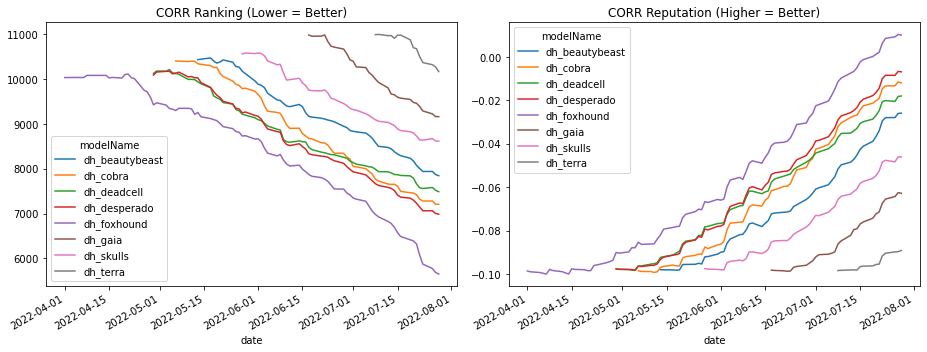

In [30]:
# plot  corr rank and rep
corrdf = rank.loc[rank["date"]>=AFTER_DATE]

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=False, figsize=(13, 5))
pd.pivot_table(
    data=corrdf[["modelName", "date", "corrRank"]],
    values="corrRank",
    index="date",
    columns="modelName"
).plot(ax=axes[0])
axes[0].set_title("CORR Ranking (Lower = Better)")

pd.pivot_table(
    data=corrdf[["modelName", "date", "corrRep"]],
    values="corrRep",
    index="date",
    columns="modelName"
).plot(ax=axes[1])
axes[1].set_title("CORR Reputation (Higher = Better)")

plt.tight_layout()
plt.savefig('plots/CorrRankPlots.png', facecolor='w')
plt.show()

---
# Model Performance by Round

In [31]:
# get round performance
perf = get_model_performance(model_list=model_list)
perf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2020 entries, 0 to 29
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype                  
---  ------                    --------------  -----                  
 0   corrPercentile            2020 non-null   float64                
 1   correlation               2020 non-null   float64                
 2   correlationWithMetamodel  2020 non-null   float64                
 3   date                      2020 non-null   datetime64[ns, tzutc()]
 4   fnc                       2020 non-null   float64                
 5   fncPercentile             2020 non-null   float64                
 6   mmc                       2020 non-null   float64                
 7   mmcPercentile             2020 non-null   float64                
 8   roundNumber               2020 non-null   int64                  
 9   tc                        1429 non-null   float64                
 10  tcPercentile              1429 non-nul

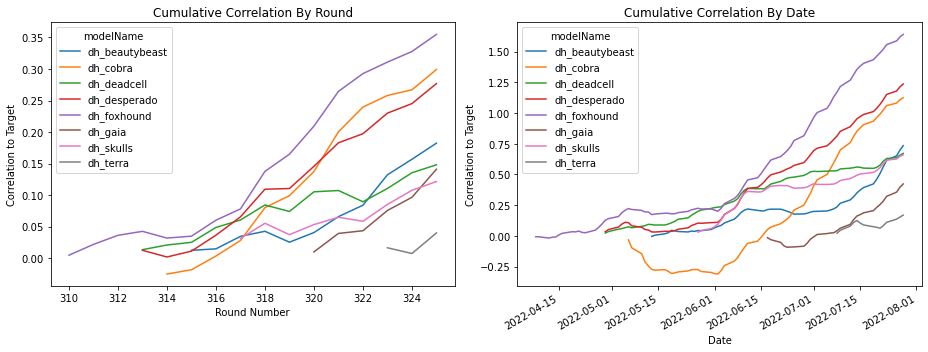

In [32]:
# get mean corr by round
avg_corr_by_era = get_model_performance_aggregated(score="correlation", by="roundNumber")
avg_corr_by_date = get_model_performance_aggregated(score="correlation", by="date")

# plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))
avg_corr_by_era.loc[AFTER_ERA:].cumsum().plot(ax=axes[0])
avg_corr_by_date.loc[AFTER_DATE:].cumsum().plot(ax=axes[1])
axes[0].set_title("Cumulative Correlation By Round")
axes[0].set_xlabel("Round Number")
axes[0].set_ylabel("Correlation to Target")
axes[1].set_title("Cumulative Correlation By Date")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Correlation to Target")
plt.tight_layout()
plt.savefig('plots/ModelCorrPlots.png', facecolor='w')
plt.show()

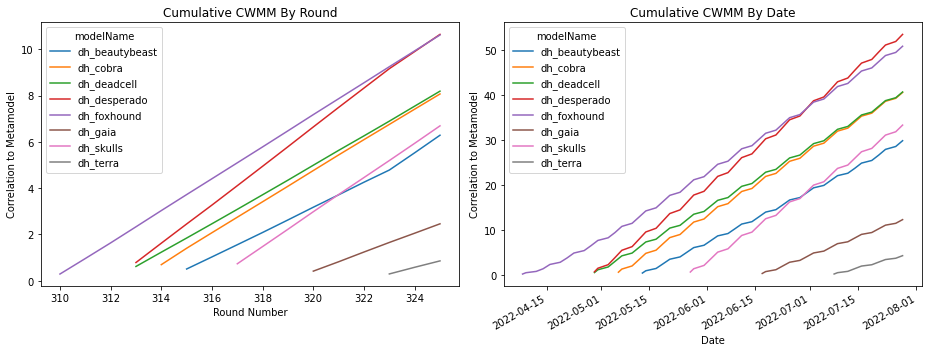

In [33]:
# get mean cwmm by round
avg_cwmm_by_era = get_model_performance_aggregated(score="correlationWithMetamodel", by="roundNumber")
avg_cwmm_by_date = get_model_performance_aggregated(score="correlationWithMetamodel", by="date")

# plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))
avg_cwmm_by_era.loc[AFTER_ERA:].cumsum().plot(ax=axes[0])
avg_cwmm_by_date.loc[AFTER_DATE:].cumsum().plot(ax=axes[1])
axes[0].set_title("Cumulative CWMM By Round")
axes[0].set_xlabel("Round Number")
axes[0].set_ylabel("Correlation to Metamodel")
axes[1].set_title("Cumulative CWMM By Date")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Correlation to Metamodel")
plt.tight_layout()
plt.savefig('plots/ModelCWMMPlots.png', facecolor='w')
plt.show()

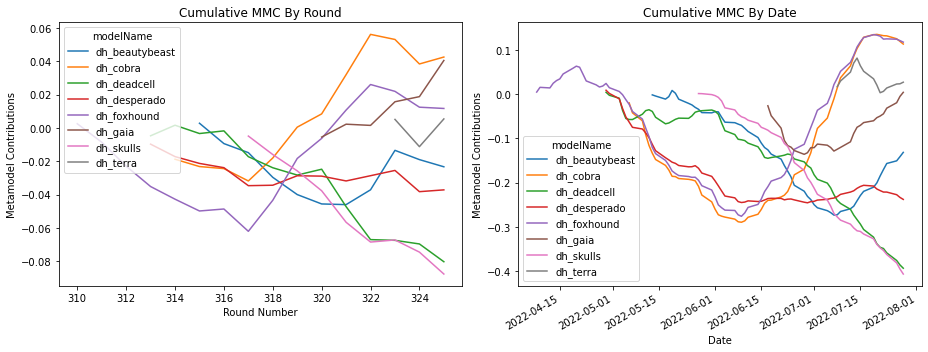

In [34]:
# get mean mmc by round
avg_mmc_by_era = get_model_performance_aggregated(score="mmc", by="roundNumber")
avg_mmc_by_date = get_model_performance_aggregated(score="mmc", by="date")

# plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))
avg_mmc_by_era.loc[AFTER_ERA:].cumsum().plot(ax=axes[0])
avg_mmc_by_date.loc[AFTER_DATE:].cumsum().plot(ax=axes[1])
axes[0].set_title("Cumulative MMC By Round")
axes[0].set_xlabel("Round Number")
axes[0].set_ylabel("Metamodel Contributions")
axes[1].set_title("Cumulative MMC By Date")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Metamodel Contributions")
plt.tight_layout()
plt.savefig('plots/ModelMMCPlots.png', facecolor='w')
plt.show()

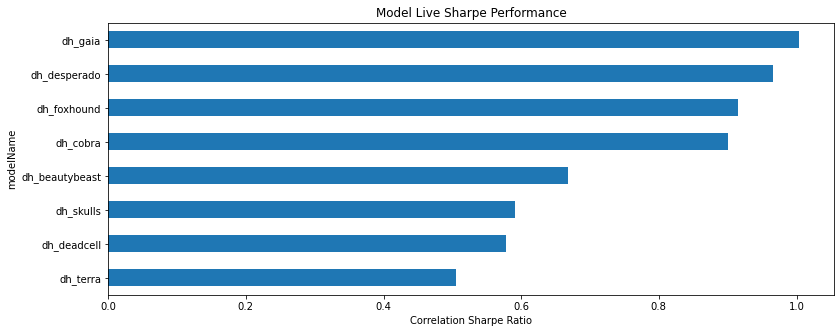

In [35]:
# rank by sharpe on correlation
def get_sharpe(x):
    return x.mean() / x.std()

perf_clean = perf.loc[perf["roundNumber"]>=AFTER_ERA]
sharpe_df = pd.concat([
    perf_clean.groupby("modelName")["correlation"].size(),
    perf_clean.groupby("modelName")["correlation"].apply(lambda x: get_sharpe(x))], 
    axis=1)
sharpe_df.columns = ["n", "sharpe"]
sharpe_df = sharpe_df.loc[sharpe_df["n"]>=10].sort_values("sharpe")

sharpe_df["sharpe"].plot.barh(figsize=(13, 5))
plt.title("Model Live Sharpe Performance")
plt.xlabel("Correlation Sharpe Ratio")
plt.savefig('plots/CorrSharpeRatioPlots.png', facecolor='w')
plt.show();

---
# Model Payouts & Staking

In [36]:
# get payout
payout = get_model_value(model_list, "payout")
payout.tail()

modelName,dh_beautybeast,dh_cobra,dh_deadcell,dh_desperado,dh_foxhound,dh_gaia,dh_skulls,totalValue
roundResolveTime,,,,,,,,
2022-06-30 20:00:00+00:00,-0.010934,0.022365,-0.010120,0.010655,0.062886,0.0,0.000000,0.074851
2022-07-07 20:00:00+00:00,-0.002884,-0.011732,-0.030117,-0.192057,0.020493,0.0,-0.047606,-0.263904
2022-07-14 20:00:00+00:00,0.001048,0.078808,-0.008101,0.532982,0.751772,0.0,0.011680,1.368190
2022-07-21 20:00:00+00:00,0.026503,0.062299,-0.039632,0.416407,0.687403,0.0,0.024029,1.177009
2022-07-28 20:00:00+00:00,0.024153,0.015278,-0.032808,0.262563,0.566427,0.0,0.011744,0.847357


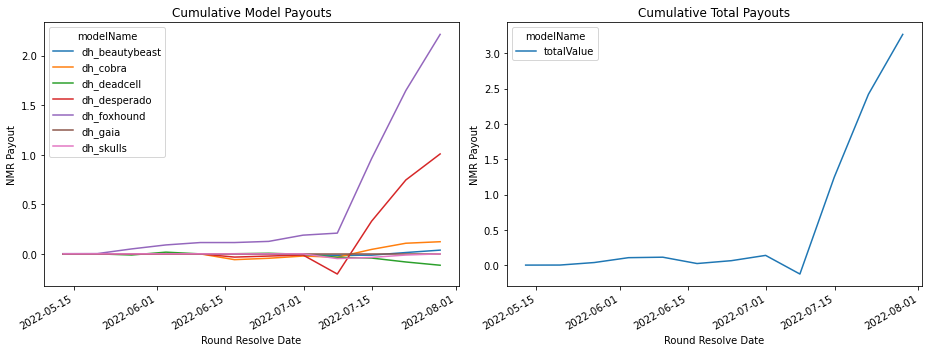

In [37]:
# plot payouts
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))
payout.loc[AFTER_DATE:][[col for col in payout.columns if col.startswith("dh_")]].cumsum().plot(ax=axes[0])
payout.loc[AFTER_DATE:][["totalValue"]].cumsum().plot(ax=axes[1])
axes[0].set_title("Cumulative Model Payouts")
axes[0].set_xlabel("Round Resolve Date")
axes[0].set_ylabel("NMR Payout")
axes[1].set_title("Cumulative Total Payouts")
axes[1].set_xlabel("Round Resolve Date")
axes[1].set_ylabel("NMR Payout")
plt.tight_layout()
plt.savefig('plots/PayoutPlots.png', facecolor='w')
plt.show()

In [38]:
# get payout
staking = get_model_value(model_list, "staking")
staking.tail()

modelName,dh_beautybeast,dh_cobra,dh_deadcell,dh_desperado,dh_foxhound,dh_gaia,dh_skulls,totalValue
roundResolveTime,,,,,,,,
2022-06-30 20:00:00+00:00,1.000000,1.000000,0.988481,1.000000,1.049794,0.0,0.0,5.038274
2022-07-07 20:00:00+00:00,1.000000,1.000000,1.017107,15.000000,1.090052,0.0,1.0,20.107158
2022-07-14 20:00:00+00:00,1.000000,1.000000,0.999823,15.000000,15.114048,0.0,1.0,34.113872
2022-07-21 20:00:00+00:00,1.000000,0.941385,1.001265,14.967372,15.114160,0.0,1.0,34.024183
2022-07-28 20:00:00+00:00,0.999667,0.955421,1.005958,14.977791,15.125796,0.0,1.0,34.064633


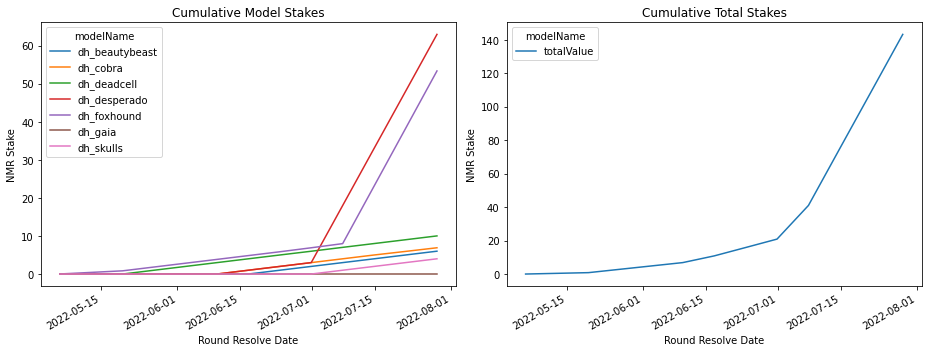

In [39]:
# plot payouts
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))
staking.loc[AFTER_DATE:][[col for col in staking.columns if col.startswith("dh_")]].cumsum().plot(ax=axes[0])
staking.loc[AFTER_DATE:][["totalValue"]].cumsum().plot(ax=axes[1])
axes[0].set_title("Cumulative Model Stakes")
axes[0].set_xlabel("Round Resolve Date")
axes[0].set_ylabel("NMR Stake")
axes[1].set_title("Cumulative Total Stakes")
axes[1].set_xlabel("Round Resolve Date")
axes[1].set_ylabel("NMR Stake")
plt.tight_layout()
plt.savefig('plots/ModelStakingPlots.png', facecolor='w')
plt.show()

---
# Total Return

In [40]:
# get return
total_return = pd.concat([payout.sum(), staking.tail(1).T], axis=1)
total_return.columns = ["payout", "staking"]
total_return["return"] = total_return["payout"] / total_return["staking"]

total_return

,payout,staking,return
modelName,,,
dh_beautybeast,0.037553,0.999667,0.037565
dh_cobra,0.122440,0.955421,0.128153
dh_deadcell,-0.114819,1.005958,-0.114139
dh_desperado,1.008340,14.977791,0.067322
dh_foxhound,2.219226,15.125796,0.146718
dh_gaia,0.000000,0.000000,NaN
dh_skulls,-0.000153,1.000000,-0.000153
totalValue,3.272587,34.064633,0.096070


In [41]:
# daily staking 
round_return = pd.concat([payout["totalValue"], staking["totalValue"]], axis=1)[AFTER_DATE:].fillna(0)
round_return.columns = ["payout", "staking"]
round_return["return"] = round_return["payout"] / round_return["staking"]

round_return

,payout,staking,return
roundResolveTime,,,
2022-05-05 20:00:00+00:00,0.000000,0.014453,0.000000
2022-05-12 20:00:00+00:00,0.002033,0.414453,0.004906
2022-05-19 20:00:00+00:00,0.000667,0.414453,0.001609
2022-05-26 20:00:00+00:00,0.035571,2.000003,0.017785
2022-06-02 20:00:00+00:00,0.068884,2.000003,0.034442
2022-06-09 20:00:00+00:00,0.006714,2.000003,0.003357
2022-06-16 20:00:00+00:00,-0.089689,4.002037,-0.022411
2022-06-23 20:00:00+00:00,0.040450,5.002704,0.008086
2022-06-30 20:00:00+00:00,0.074851,5.038274,0.014857


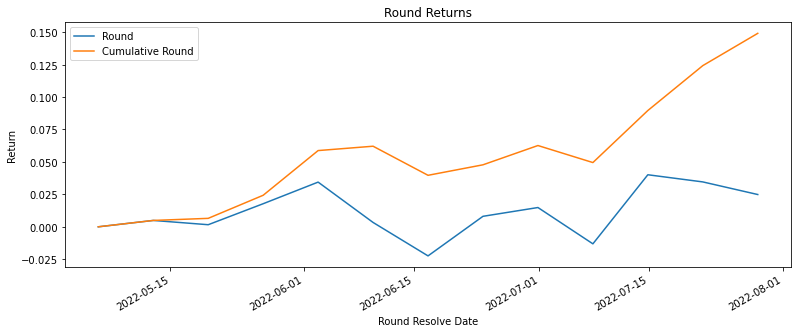

In [42]:
# plot round return
plt.figure(figsize=(13, 5))
round_return["return"].plot()
round_return["return"].cumsum().plot()
plt.legend(["Round", "Cumulative Round"])
plt.title("Round Returns")
plt.xlabel("Round Resolve Date")
plt.ylabel("Return")
plt.savefig('plots/TotalReturnPlots.png', facecolor='w')
plt.show()